# SST anomalies
Plot the SST anomalies for the Global Ocean or for regional domains.    
Prepared to work with MODIS-Terra SST 4 µm nightime data, at 9 km resolution, download from [Ocean Color](https://oceancolor.gsfc.nasa.gov/).

In [1]:
import sys
sys.path.insert(0, '..')
import os
import glob
import numpy as np
from filament import filament
import datetime
import cmocean
import logging
import calendar
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
coast_l = cfeature.GSHHSFeature(scale="l")
coast_f = cfeature.GSHHSFeature(scale="f")

datacrs = ccrs.PlateCarree()
plt.style.use("filament.mplstyle")

## Logger

In [2]:
logger = logging.getLogger("SSTanom")
logger.setLevel(logging.INFO)
logging.info("Starting")

In [3]:
from matplotlib.font_manager import FontProperties
fontfile = "/home/ctroupin/.fonts/Barlow-Regular.ttf"
#fontfile = "/home/ctroupin/.fonts/DS-DIGI.TTF"
if os.path.exists(fontfile):
    myfont = FontProperties(fname=fontfile)
else:
    logger.warn("Font file not found")

## Files and directories

In [4]:
yearlist = range(2000, 2025)
regionname = "Canary"

sat = "TERRA"
sensor = "MODIS"
figdir = f"/home/ctroupin/data/SST/Global/figures/anim/{regionname}"
figdirpolar = "/home/ctroupin/data/SST/Global/figures/polar"

monthlydir = "/home/ctroupin/data/SST/Global/monthly/"
climdir = "/home/ctroupin/data/SST/Global/monthly_clim/"

if not os.path.exists(figdir):
    os.makedirs(figdir)

bgcolor = "black"
fgcolor = "white"

doplotanom = False
doplotfield = False

## Plot preparation
### Projection
Extract the coordinates from one the file

In [14]:
monthlydir0 = f"{monthlydir}/{yearlist[0]}"
sstmonthfile = filament.get_monthly_filename(sat, sensor, yearlist[0], 2)
SSTmonth = filament.SST()
SSTmonth.read_from_oceancolorL3(os.path.join(monthlydir0, sstmonthfile))
llon, llat = np.meshgrid(SSTmonth.lon, SSTmonth.lat)
sst_extent = [SSTmonth.lon.min(), SSTmonth.lon.max(), SSTmonth.lat.min(), SSTmonth.lat.max()]
sst_extent

[-179.95833, 179.95836, -89.958336, 89.958336]

In [15]:
myproj = ccrs.Orthographic(central_longitude=-20.0, central_latitude=20.0, globe=None)
myproj

<Projected CRS: +proj=ortho +a=6378137.0 +lon_0=-20.0 +lat_0=20.0  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Orthographic
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [16]:
regions_coords = {"MedSea": (-7, 17, 30., 48.),
                  "Canary": (-18.5, -13., 26., 31),
                  "Atlantic": (-80., 0., 0., 40.),
                  "Balearic": (1., 4.5, 38.5, 40.25),}
coordinates = regions_coords[regionname]

myproj = ccrs.Mercator(central_longitude=0.5 * (coordinates[0] + coordinates[1]), 
                              min_latitude=coordinates[2], max_latitude=coordinates[3])
myproj

<Projected CRS: +proj=merc +ellps=WGS84 +lon_0=-15.75 +x_0=0.0 +y_ ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant A)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Plotting function

In [8]:
def make_monthly_subplot(SSTanom, month, NN=1, fgcolor="k", figtitle=None, year=None,
                        colorbar=True):
    
  
    
    pcm = ax.imshow(SSTanom[::NN,::NN], extent=coordinates, cmap=plt.cm.RdBu_r, 
                    vmin=-2.5, vmax=2.5, zorder=2, transform=datacrs)
    
    ax.add_feature(coast_f, linewidth=.2, color=".15", zorder=5)
        
    if colorbar:
        cmap = mpl.cm.RdBu_r
        cmap.set_bad(color='grey')
        normanom = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
        cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
        cb = plt.colorbar(pcm, cax=cbar_ax, shrink=.7, cmap=cmap, norm=normanom,
                     orientation='horizontal', extend="both")
        cb.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")
        cb.ax.tick_params(axis='x', colors=fgcolor)
    
    #m.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)
    #m.drawcoastlines(linewidth=.2, zorder=4, color="grey")
    #plt.savefig(os.path.join(figdir, "SST_anom_test"), dpi=300, bbox_inches="tight")
    # plt.show()
    #plt.close()
    return pcm

In [9]:
def make_monthly_SST_subplot(SST, NN=1, fgcolor="k"):
    
    pcm = ax.imshow(SST.field[::NN,::NN], extent=sst_extent, cmap=plt.cm.RdYlBu_r, 
                    vmin=0., vmax=30., zorder=2, transform=datacrs)
    ax.add_feature(coast, linewidth=.2, color=".15", zorder=5)
        
    cmap = mpl.cm.RdYlBu_r
    cmap.set_bad(color='grey')
    normfield = mpl.colors.Normalize(vmin=0., vmax=30.)
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
    cb = plt.colorbar(pcm, cax=cbar_ax, shrink=.7, cmap=cmap, norm=normfield,
                 orientation='horizontal', extend="both")
    cb.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")
    cb.ax.tick_params(axis='x', colors=fgcolor)
    
    #m.warpimage("world.topo.bathy.200403.3x5400x2700.jpg", zorder=2)
    #m.drawcoastlines(linewidth=.2, zorder=4, color="grey")
    #plt.savefig(os.path.join(figdir, "SST_anom_test"), dpi=300, bbox_inches="tight")
    # plt.show()
    #plt.close()
    return pcm

## Plot

In [20]:
doplotanom = False

In [22]:
plt.close("all")

SSTmeantime = [] 
SSTmeananom = []

for year in yearlist:
    logger.info("Working on year {}".format(year))
    monthlydiryear = f"{monthlydir}/{year}"


    #fig = plt.figure(figsize=(13, 10), facecolor=bgcolor)

    for imonth in range(1, 13):
        if imonth == 1:
            yearstart = 2001
        else: 
            yearstart = 2000
        if imonth <= 5:
            yearend = datetime.date.today().year
        else:
            yearend = datetime.date.today().year - 1


        sstclimfile = filament.get_monthly_clim_filename(sat, sensor, yearstart, yearend, imonth, res="9km")
        sstmonthfile = filament.get_monthly_filename(sat, sensor, year, imonth, res="9km")
        sstclimfile = os.path.join(climdir, sstclimfile)
        sstmonthfile = os.path.join(monthlydiryear, sstmonthfile)

        if os.path.exists(sstclimfile) & os.path.exists(sstmonthfile):
            logger.info("Working on month {}/12 year {}".format(imonth, year))

            # Read data (lon, lat and SST)
            logger.info("Reading data from netCDF files")
            SSTmonth = filament.SST()
            SSTmonth.read_from_oceancolorL3(sstmonthfile, domain=coordinates)
            SSTclim = filament.SST()
            SSTclim.read_from_oceancolorL3(sstclimfile, domain=coordinates)

            # Compute anomalies
            SSTanom = SSTmonth.field - SSTclim.field

            
            SSTmeantime.append(datetime.date(year, imonth, 1))
            SSTmeananom.append(SSTanom.mean())
            
            # SST anomalies
            
            if doplotanom:
                
                 # Individual figures
                logger.info("Creating anomalies figure")
            
                fig = plt.figure(1, figsize=(12, 12), facecolor=bgcolor)
                ax = plt.subplot(111, projection=myproj)
                ax.set_extent(coordinates)

                figtitle = "{} / {}".format(str(imonth).zfill(2), year)
                pcm = make_monthly_subplot(SSTanom, imonth+1, NN=1, fgcolor=fgcolor, 
                                           figtitle=figtitle)
                
                ax.text(0.02, 0.98, figtitle, horizontalalignment='left',
                        verticalalignment='top', fontsize=30, 
                        color=fgcolor, fontproperties=myfont,
                        transform = ax.transAxes)
                
                
                #plt.annotate(figtitle, xy=(0, 1), xycoords='axes fraction', fontsize=30, 
                #             color=fgcolor, fontproperties=myfont)
                

                logger.info("Saving figure")
                plt.savefig(os.path.join(figdir, "SSTanomalies_{}_{}.jpg".format(year, str(imonth).zfill(2))), 
                            facecolor=fig.get_facecolor())
                # plt.show()
                fig.clf()
                
            if doplotfield:
                
                logger.info("Creating SST figure")
                
                fig = plt.figure(1, figsize=(12, 12), facecolor=bgcolor)
                ax = plt.subplot(111, projection=myproj)

                figtitle = "{} / {}".format(str(imonth).zfill(2), year)
                
                ax.text(0.01, 1, figtitle, horizontalalignment='left',
                        verticalalignment='top', fontsize=30, 
                        color=fgcolor, fontproperties=myfont, 
                        transform = ax.transAxes)
                
                #plt.annotate(figtitle, xy=(0, 1), xycoords='axes fraction', fontsize=30, 
                #             color=fgcolor, fontproperties=myfont)
                pcm = make_monthly_SST_subplot(SSTmonth, NN=1, fgcolor=fgcolor)


                logger.info("Saving figure")
                plt.savefig(os.path.join(figdir2, "SSTfield_RdBu_{}_{}.jpg".format(year, str(imonth).zfill(2))), 
                            facecolor=fig.get_facecolor(),
                            dpi=300, bbox_inches="tight")
                #plt.show()
                fig.clf()
            
            plt.close("all")
            
        else:
            logger.warning("Missing files...")
            
            """
            logger.info("Preparing global figure")
            # Global figure
            ax = plt.subplot(3, 4, imonth)
            pcm = make_monthly_subplot(m, lonp, latp, SSTanom, imonth, NN=10, 
                                       fgcolor=fgcolor, figtitle=calendar.month_name[imonth])
        


    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
    normanom = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.RdBu_r,
                                    norm=normanom, orientation='vertical', 
                                    extend="both")

    cb1.set_label("$^{\circ}$C", rotation=0, ha="left", fontsize=18, 
                  color=fgcolor, fontweight="bold")

    cb1.ax.tick_params(axis='y', colors=fgcolor)


    cb1_ytl = cb1.ax.get_yticklabels()
    cb1.ax.set_yticklabels(cb1_ytl, color=fgcolor, 
                           fontweight="bold", fontsize=16)


    fig.suptitle('Sea surface temperature anomalies $-$ {}'.format(year), 
                 fontsize=24, color=fgcolor) 
                 
    logger.info("Saving global figure for year {}".format(year))
    plt.savefig(os.path.join(figdir, "SSTanomalies{}_test".format(year)), 
                facecolor=fig.get_facecolor(),
                dpi=300, bbox_inches="tight")
    #plt.show()
    plt.close()
    """

INFO:SSTanom:Working on year 2000
INFO:SSTanom:Working on month 2/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 3/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 4/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 5/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 6/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 7/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 8/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 9/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 10/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 11/12 year 2000
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 12/12 year 2000
INFO:SSTanom:Reading data fr

INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 7/12 year 2007
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 8/12 year 2007
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 9/12 year 2007
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 10/12 year 2007
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 11/12 year 2007
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 12/12 year 2007
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on year 2008
INFO:SSTanom:Working on month 1/12 year 2008
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 2/12 year 2008
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 3/12 year 2008
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 4/12 year 2008
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month

INFO:SSTanom:Working on month 12/12 year 2014
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on year 2015
INFO:SSTanom:Working on month 1/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 2/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 3/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 4/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 5/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 6/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 7/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 8/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 9/12 year 2015
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 10/12 year 2015
INFO:SSTanom:Reading data fro

INFO:SSTanom:Working on month 5/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 6/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 7/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 8/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 9/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 10/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 11/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 12/12 year 2022
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on year 2023
INFO:SSTanom:Working on month 1/12 year 2023
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 2/12 year 2023
INFO:SSTanom:Reading data from netCDF files
INFO:SSTanom:Working on month 3/12 year 2023
INFO:SSTanom:Reading data fr

In [48]:
def make_empty_subplot(fgcolor="k", figtitle=None):
    
    fig = plt.figure(1, figsize=(12, 12), facecolor=bgcolor)
    ax = plt.subplot(111, projection=myproj)
    if figtitle is not None:
        plt.title(figtitle, fontsize=18, color=fgcolor)
    ax.add_feature(coast, linewidth=.2, color=".85", zorder=5)
    
    plt.savefig(os.path.join(figdir, "SSTanomalies_empty"), 
                        facecolor=fig.get_facecolor(),
                        dpi=300, bbox_inches="tight")
    plt.close()

In [49]:
make_empty_subplot(fgcolor="k", figtitle=None)

### Plot the colorbar alone

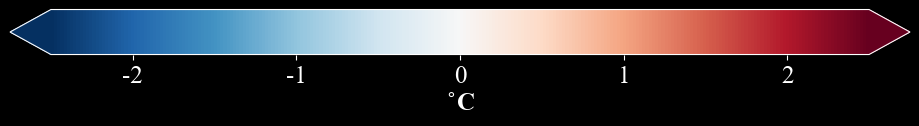

In [19]:
# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(10, 3), facecolor=bgcolor)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.RdBu_r
normanom = mpl.colors.Normalize(vmin=-2.5, vmax=2.5)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=normanom,
                                orientation='horizontal', extend="both", format='%d')

cb1.set_label("$^{\circ}$C", fontsize=18, color=fgcolor, fontweight="bold")

cb1.ax.tick_params(axis='x', colors=fgcolor)
#cb1.ax.set_xticklabels(np.arange(-2., 2.1), color=fgcolor,  
#                       fontsize=16)

plt.savefig(os.path.join(figdir, "sst_colorbar.png"), dpi=300, bbox_inches="tight",
            facecolor=fig.get_facecolor())
plt.show()

## Time series
### Linear plot

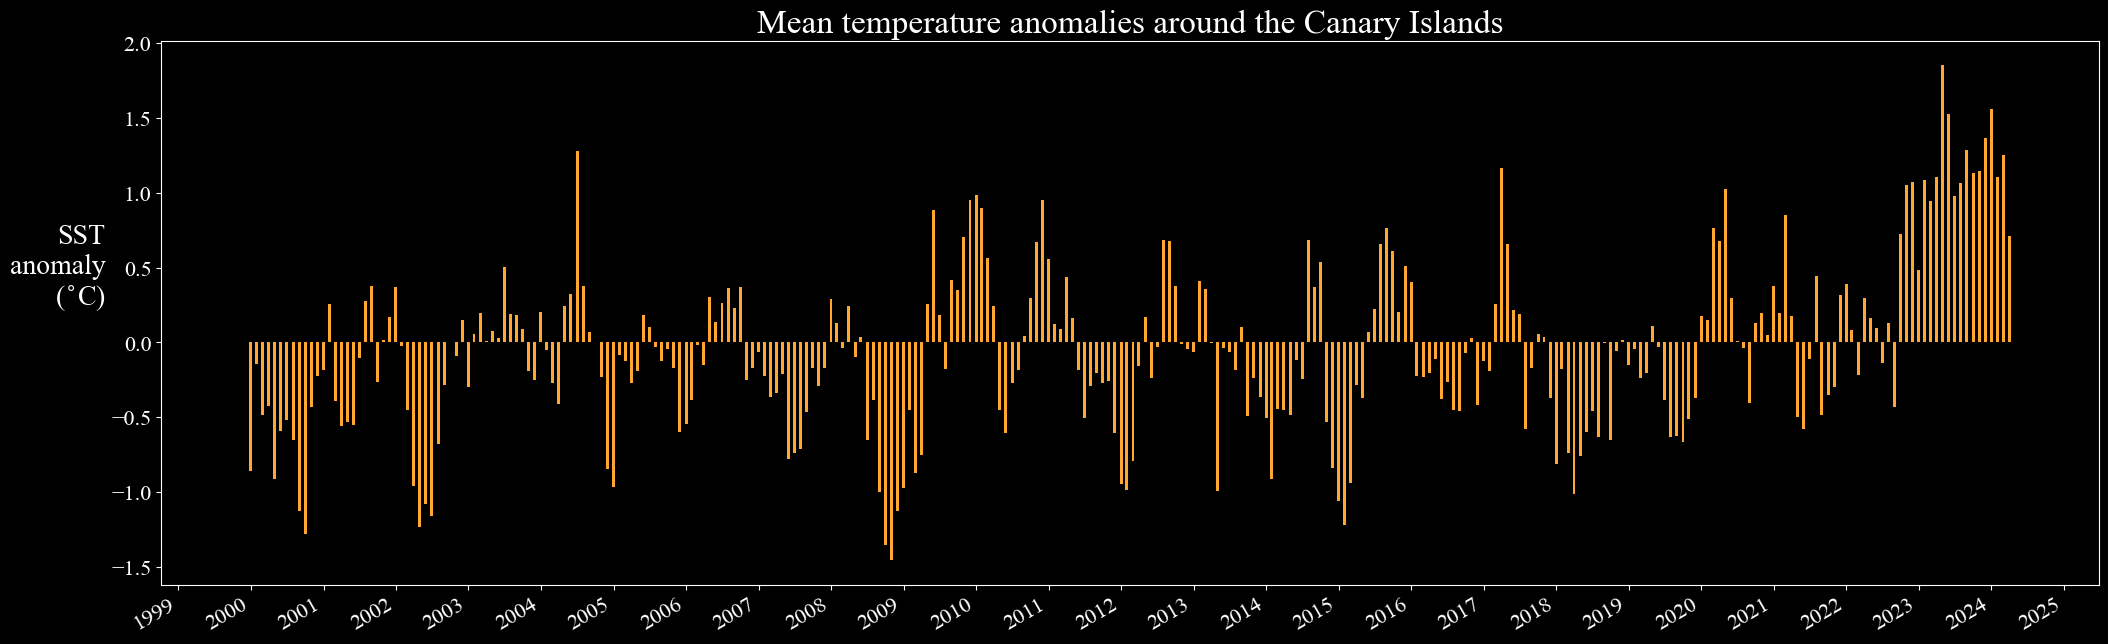

In [25]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 8), facecolor=bgcolor)
ax = plt.subplot(111)
plt.bar(SSTmeantime, SSTmeananom, color="#FFA731", width=15)
plt.xticks([datetime.date(yyyy, 1, 1) for yyyy in range(2000, 2021)])
plt.ylabel("SST\nanomaly\n($^{\circ}$C)", rotation=0, ha="right", fontsize=20)

# Format time
fmt_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title("Mean temperature anomalies around the Canary Islands")
fig.autofmt_xdate()
plt.savefig(os.path.join(figdir, "Canary_mean_SST.png"), facecolor=fig.get_facecolor())
plt.show()

### Polar plot

In [135]:
monthlist = np.array([s.month for s in SSTmeantime])
yearlist = np.array([s.year for s in SSTmeantime])
anglelist = (monthlist - 1.) * np.pi / 6.

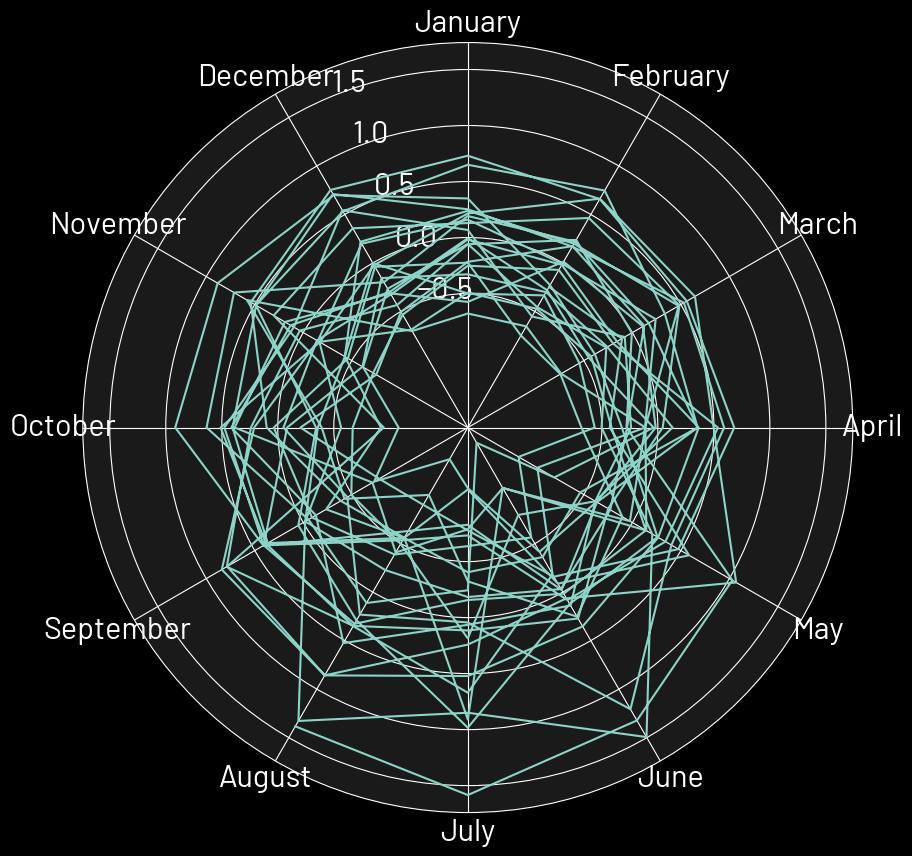

In [100]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.set_facecolor('.1')
ax.set_rticks([-0.5, 0., 0.5, 1, 1.5, 2])  # less radial ticks
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 30), labels=[calendar.month_name[ii] for ii in range(1, 13)], 
                  fontsize=20, fontproperties=myfont)
plt.setp(ax.get_xticklabels(), fontproperties=myfont, fontsize=22)
plt.setp(ax.get_yticklabels(), fontproperties=myfont, fontsize=22)
#ax.scatter(anglelist, SSTmeananom, c=yearlist, s=40, cmap=plt.cm.RdYlBu_r)
ax.plot(anglelist, SSTmeananom)

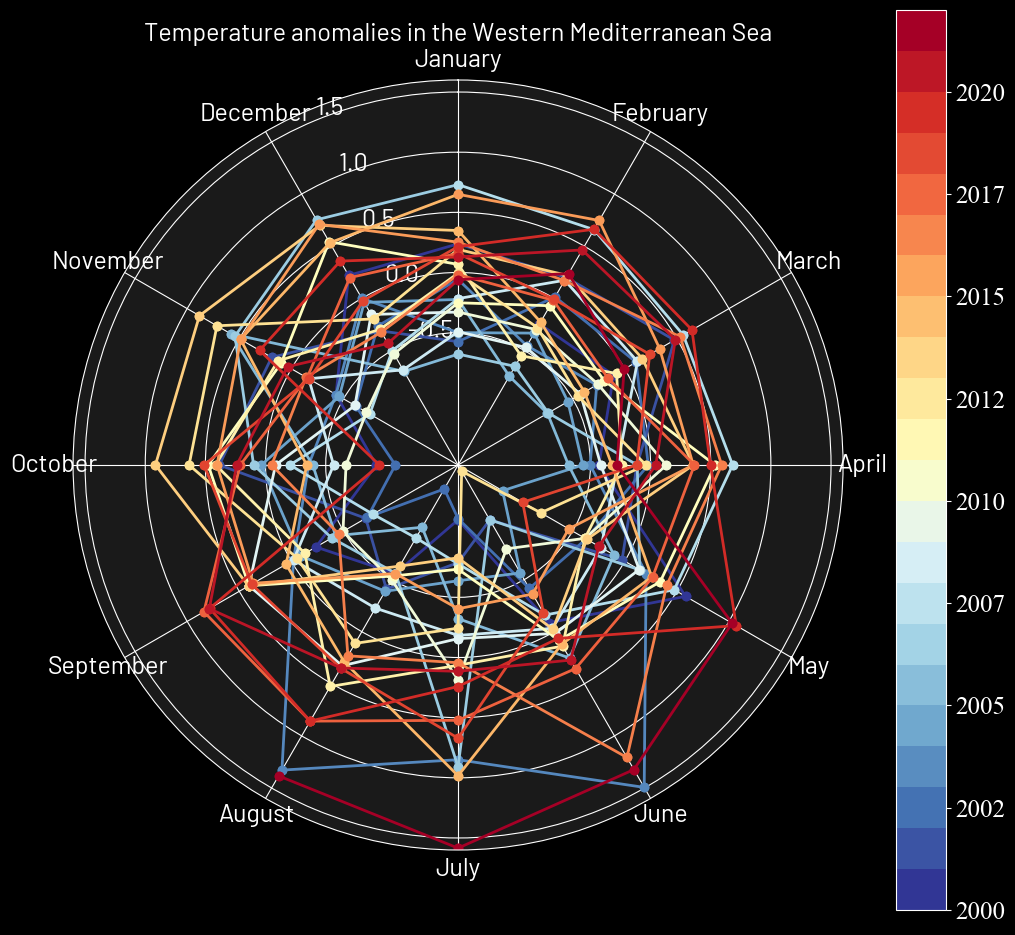

In [127]:
plt.style.use('dark_background')
yearnorm = colors.Normalize(vmin=2000, vmax=2022)
yearcmap = plt.cm.get_cmap('RdYlBu_r', 22)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.set_facecolor('.1')
ax.set_rticks([-0.5, 0., 0.5, 1, 1.5, 2])  # less radial ticks
ax.set_rlim(-1.6, 1.6)
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 30), labels=[calendar.month_name[ii] for ii in range(1, 13)], 
                  fontsize=20, fontproperties=myfont)
plt.setp(ax.get_xticklabels(), fontproperties=myfont, fontsize=18)
plt.setp(ax.get_yticklabels(), fontproperties=myfont, fontsize=18)
#ax.scatter(anglelist, SSTmeananom, c=yearlist, s=40, cmap=plt.cm.RdYlBu_r)

ax.set_title("Temperature anomalies in the Western Mediterranean Sea", fontproperties=myfont)



ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
cmap = mpl.cm.RdBu_r
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=yearcmap,
                                norm=yearnorm,
                                orientation='vertical', format='%d')

#cb1.set_label("$^{\circ}$C", fontsize=18, rotation=0, color=fgcolor, fontweight="bold")

cb1.ax.tick_params(axis='x', colors=fgcolor)


for ii in range(0, len(anglelist)):
    ax.plot(anglelist[ii:ii+2], SSTmeananom[ii:ii+2], "o-", 
            color=plt.cm.RdYlBu_r(norm(yearlist[ii])), linewidth=2)
    iiii = str(ii).zfill(4)
    plt.savefig(os.path.join(figdirpolar, f"SST_anomalies_polar_{iiii}.png"), dpi=300, bbox_inches="tight")

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

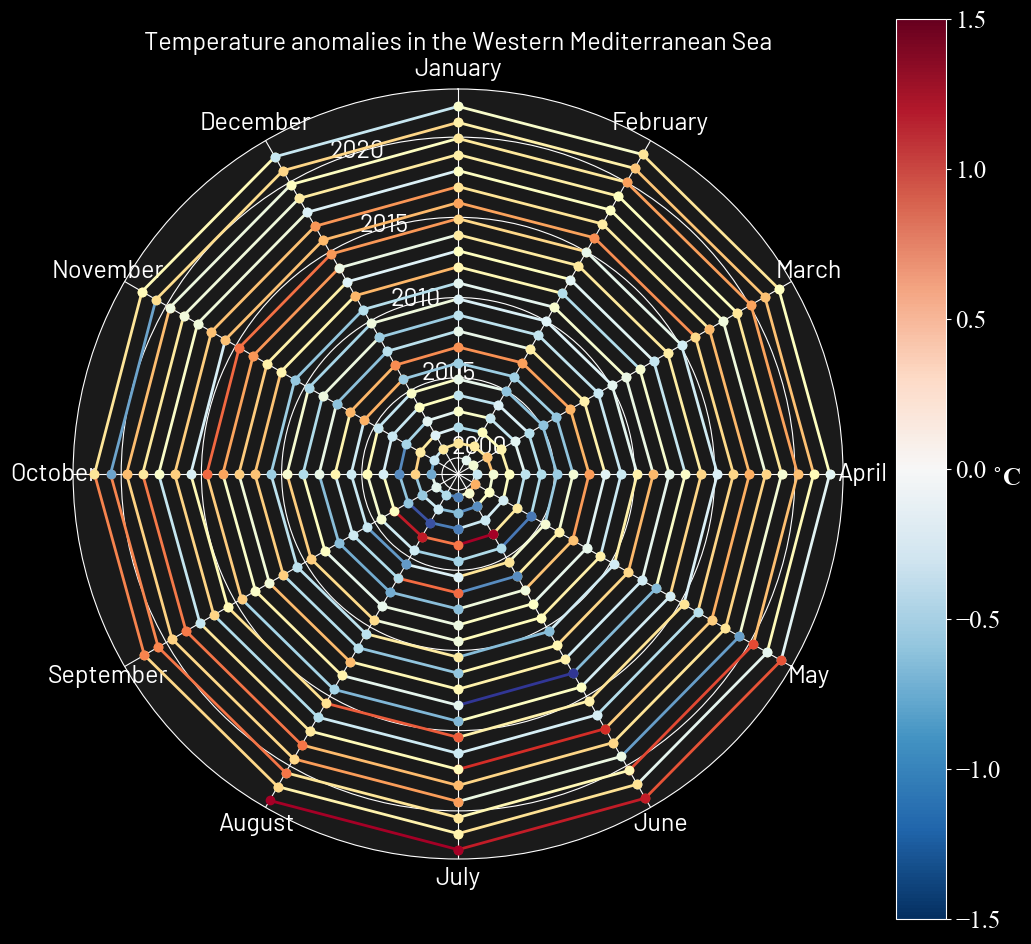

In [143]:
plt.style.use('dark_background')
sstnorm = colors.Normalize(vmin=-1.5, vmax=1.5)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.set_facecolor('.1')
#ax.set_rticks([-0.5, 0., 0.5, 1, 1.5, 2])  # less radial ticks
ax.set_rlim(1999, 2023)
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 30), labels=[calendar.month_name[ii] for ii in range(1, 13)], 
                  fontsize=20, fontproperties=myfont)
plt.setp(ax.get_xticklabels(), fontproperties=myfont, fontsize=18)
plt.setp(ax.get_yticklabels(), fontproperties=myfont, fontsize=18)
#ax.scatter(anglelist, SSTmeananom, c=yearlist, s=40, cmap=plt.cm.RdYlBu_r)

ax.set_title("Temperature anomalies in the Western Mediterranean Sea", fontproperties=myfont)

ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
cmap = mpl.cm.RdBu_r
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                norm=sstnorm,
                                orientation='vertical')
cb1.set_label("$^{\circ}$C", fontsize=18, rotation=0, color=fgcolor, fontweight="bold")

cb1.ax.tick_params(axis='x', colors=fgcolor)


for ii in range(0, len(anglelist)):
    ax.plot(anglelist[ii:ii+2], yearlistfrac[ii:ii+2], "o-", 
            color=plt.cm.RdYlBu_r(sstnorm(SSTmeananom[ii])), linewidth=2)
    iiii = str(ii).zfill(4)
    plt.savefig(os.path.join(figdirpolar2, f"SST_anomalies_polar_{iiii}.png"), dpi=300, bbox_inches="tight")

In [141]:
yearlistfrac = np.arange(2000, 2023, 1/12)
len(yearlistfrac), len(yearlist)

(276, 271)

In [ ]:
with netCDF4.Dataset(" http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCDC/.OISST/.version2p1/.AVHRR_monthly/.anom_c9120/dods") as ds:
    times = ds.variables["T"][:]
    timeunits = ds.variables["T"].units
    lon = ds.variables["lon"][:]
    lat = ds.variables["lat"][:]
    lon[lon>180] -= 360
    goodlon = np.where((lon >= coordinates[0]) & (lon <= coordinates[1]))[0]
    goodlat = np.where((lat >= coordinates[2]) & (lat <= coordinates[3]))[0]

    lon_oisst = lon[goodlon]
    lat_oisst = lat[goodlat]
    SSTanom_oisst = ds.variables["anom_c9120"][:,0,goodlat,goodlon]

In [72]:
lon2 = lon
lon2[lon2>180] -= 360
lon2

masked_array(data=[ 0.125,  0.375,  0.625, ..., -0.625, -0.375, -0.125],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [85]:
goodlon = np.where((lon2 >= coordinates[0]) & (lon2 <= coordinates[1]))
goodlon

(array([1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376,
        1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387]),)

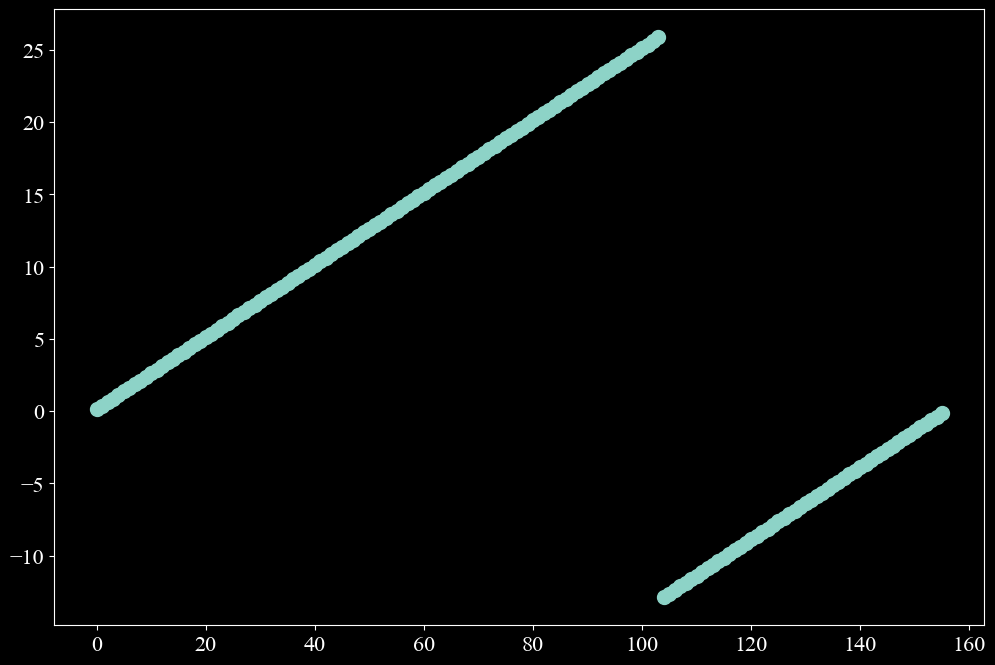

In [81]:
plt.plot(lon2[goodlon], "o")